# What can we learn about API design for data science?

There are a lot of different ways of spelling out functionality in APIs and some of them are painful, while others are highly usable. We may be able to learn things about API design by looking at what APIs people are using and how. Help to design good APIs by advising the granularity questions (lots of small objects/functions, or a few with lots or arguments)? 

- Lines of code
    - On average, code cells have 6.69 lines of code (median = 2).
- Variables
    - On average, there are 13.76 object definitions in a notebook (median = 10).
- Parameters
    - Across all function calls, there are an average of 1.057 arguments per function. 
    - On average, a call to a user defined function has 1.65 parameters.
    - On average, a call to a non user-defined function has 1.017 parameters.
    - This is a statistically significant difference. We are 95% confident that the true average number of parameters in user-defined function calls is between 0.62 and 0.64 higher than the average number of parameters in non user-defined function calls.

- Functions
    - On average, there are 2.43 function calls per code cell and 32.04 function calls per notebook.
    - On average, a user defines 1.84 functions per notebooks. Each user-defined function is called, on average, 1.595 times in a notebook.
    - On average, a user uses 8.083 unique non user-defined functions per notebooks. A non user-defined function is used, on average, 1.461 times in a notebook.
    - There is a statistically significant difference in the average number of times a function is called between user-defined and non user-defined functions. We are 95% confident that the true average number of calls to a user-defined function is between 0.12 and 0.15 higher than the average number of calls to a non user-defined function.
-----


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import datetime
import math
from collections import deque
import scipy.stats as st
import ast
import astpretty


import load_data
notebooks, cells, owners, readmes, repos = load_data.load(lang = 'python')

In [3]:
cells['all_code'] = ['\n'.join([c for c in code if not c.startswith('%')]) for code in cells['code']]
cells['all_markdown'] = [[' '.join(m) for m in mark if type(m) == list] for mark in cells['markdown']]
cells['num_display_keys'] = [len(c) for c in cells['display_data_keys']]
cells['num_headings'] = [len(c) for c in cells['headings']]


In [4]:
cells = cells.copy()[cells.cell_type == 'code']
flatten = lambda l: [item for sublist in l for item in sublist]


# How long are code cells?

In [5]:
cells[cells.cell_type=='code'].lines_of_code.aggregate(['mean','median','min','max'])


mean         6.692396
median       2.000000
min          0.000000
max       1077.000000
Name: lines_of_code, dtype: float64

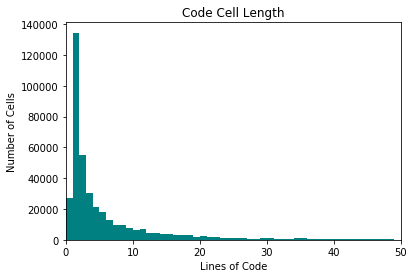

In [6]:
plt.hist(cells[cells.cell_type=='code'].lines_of_code, bins = range(50), color = 'teal')
plt.xlim(0,50)
plt.xlabel('Lines of Code')
plt.ylabel('Number of Cells')
plt.title('Code Cell Length')
plt.show()


On average, code cells have 6.69 lines of code. The typical code cell has 2 lines of code (median).

# What is a typical number of objects in a notebook?

Test that my assumptions for what different assign target types are are correct.

In [7]:
test_code = """

a = 10
x, y = 23, 123
x = [1,2,3]
x[1] = 3

class Snake:
    def __init__(self, name='python'):
        self.name = name
       
my_snake = Snake()
my_snake.name = 'python3'

[x[2], my_snake.name, d] = [1, 2, 3]

"""
expected_types = [
    ast.Name,       # a = 10
    ast.Tuple,      # x, y = 23, 123
    ast.Name,       # x = [1,2,3]
    ast.Subscript,  # x[1] = 3
    ast.Name,       # my_snake = Snake()
    ast.Attribute,  # my_snake.name = 'python3'
    ast.List        # [b, c, d] = [1, 2, 3]
]


In [8]:
types = []
for t in ast.parse(test_code).body:
    if type(t) == ast.Assign:
        for target in t.targets:
            types.append(type(target))
assert types == expected_types


Find all assignments. Make sure to treat tuples and lists as multiple assignments!

In [9]:
all_objects = []
unprocessed = 0
target_types = [ast.Name,ast.Tuple,
       ast.Attribute, ast.Subscript,
       ast.List
]
for _, row in cells.iterrows():
    objects = []
    try:
        tree = ast.parse(row['all_code'])
    except:
        all_objects.append(objects)
        unprocessed += 1
        continue
 
    for t in tree.body:
        if type(t) == ast.Assign:
            value_type = type(t.value)
            for target in t.targets:
                if type(target) in [ast.Tuple, ast.List]:
                    for node in ast.walk(target):
                        if type(node) == ast.Name:
                            objects.append((node.id, type(node), value_type))
                else:
                    if type(target) == ast.Name:
                        for node in ast.walk(target):
                            if type(node) == ast.Name:
                                objects.append((node.id, type(target), value_type))

    all_objects.append(objects)
    

Make sure we have only have ast.Name type assignments.

In [10]:
pd.concat([pd.Series([a[1] for a in objs]) for objs in all_objects]).unique()


array([<class '_ast.Name'>], dtype=object)

Calculate summary statistics for the number of objects in each notebook. Only consider 'name' assigments as objects. Setting the value in a list or data frame (subscript) and altering the attributes of an object (attribute) should not count as object assignments

In [11]:
# Number of objects is the number of unique names that recieved assignments
num_objects_cell = pd.DataFrame({'num_objects':[len(set([o[0] for o in obj])) for obj in all_objects], 'file': cells['file']})
num_objects_nb = num_objects_cell.groupby('file').sum().reset_index()


In [12]:
mean_objs = num_objects_nb.num_objects.mean()
median_objs = num_objects_nb.num_objects.median()
print('On average, there are {0} object definitions in a notebook. Median = {1}.'.format(round(mean_objs, 2), median_objs))

On average, there are 13.76 object definitions in a notebook. Median = 10.0.


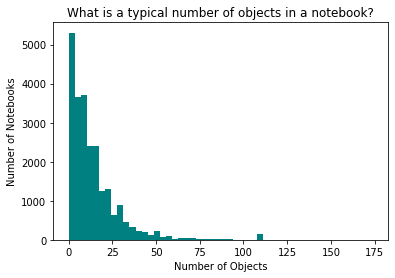

In [13]:
plt.hist(num_objects_nb.num_objects, bins = 50, color='teal')
plt.title('What is a typical number of objects in a notebook?')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Notebooks')
plt.show()

# How many arguments are typical to pass into functions?

In [14]:
'''
Get all function calls from a python file

The MIT License (MIT)
Copyright (c) 2016 Suhas S G <jargnar@gmail.com>
'''
class FuncCallVisitor(ast.NodeVisitor):
    def __init__(self):
        self._name = deque()

    @property
    def name(self):
        return '.'.join(self._name)

    @name.deleter
    def name(self):
        self._name.clear()

    def visit_Name(self, node):
        self._name.appendleft(node.id)

    def visit_Attribute(self, node):
        try:
            self._name.appendleft(node.attr)
            self._name.appendleft(node.value.id)
        except AttributeError:
            self.generic_visit(node)


def get_func_calls(tree):
    func_calls = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            callvisitor = FuncCallVisitor()
            callvisitor.visit(node.func)
            func_calls.append((callvisitor.name, [type(a) for a in node.args]))

    return func_calls


In [15]:
function_use = {
    'function': [],
    'parameters': [],
    'file': []
}
unprocessed = 0
for _, row in cells.iterrows():
    cell_funcs = []
    try:
        tree = ast.parse(row['all_code'])
    except:
        unprocessed += 1
        continue
    
    for t in tree.body:
        for f in get_func_calls(t):
            if f[0] not in cell_funcs:
                function_use['function'].append(f[0])
                function_use['parameters'].append(len(f[1]))
                function_use['file'].append(row['file'])
                cell_funcs.append(f[0])
        
function_use_df = pd.DataFrame(function_use)


In [16]:
function_use_df.head()

,function,parameters,file
0,sns.set_style,2,danielcorbett..pyoz..scratchwork..notebooks..p...
1,plt.rcParams.update,1,danielcorbett..pyoz..scratchwork..notebooks..p...
2,plt.style.use,1,danielcorbett..pyoz..scratchwork..notebooks..p...
3,np.arange,3,danielcorbett..pyoz..scratchwork..notebooks..p...
4,plt.subplots,0,danielcorbett..pyoz..scratchwork..notebooks..p...


In [87]:
all_mean_params = function_use_df.parameters.mean()
print("Across all function calls, there are an average of {0} arguments per function.".format(
    round(all_mean_params, 3)
))

Across all function calls, there are an average of 1.057 arguments per function.


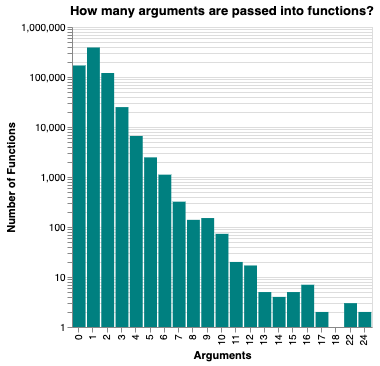

In [46]:
alt.Chart(
    function_use_df.parameters.value_counts().reset_index().rename(columns={'index':'Arguments', 'parameters': 'Count'}),
    width = 300, title = 'How many arguments are passed into functions?'
).mark_bar(color='teal').encode(
    alt.X('Arguments:O'), 
    alt.Y('Count', title = 'Number of Functions', scale = alt.Scale(type='log'))
)


## Parameters of User-defined functions

In [193]:
function_defs = {
    'function': [],
    'parameters':[],
    'file': []
}

for _, row in cells.iterrows():
    try:
        tree = ast.parse(row['all_code'])
    except:
        unprocessed += 1
        continue
    
    for t in tree.body:
        if type(t) == ast.FunctionDef:
            name = t.name
            num_args = 0
            for a in ast.walk(t.args):
                if type(a) == ast.arg:
                    num_args += 1
            function_defs['function'].append(name)
            function_defs['parameters'].append(num_args)
            function_defs['file'].append(row.file)
            
        elif type(t) == ast.ClassDef:
            name = t.name
            num_args = 0
            for b in t.body:
                if type(b) == ast.FunctionDef and b.name == '__init__':
                    for a in ast.walk(b.args):
                        if type(a) == ast.arg and a.arg != 'self':
                            num_args += 1
                elif type(b) == ast.FunctionDef:
                    name_b = name+"."+b.name
                    num_args_b = 0
                    for a in ast.walk(b.args):
                        if type(a) == ast.arg and a.arg != 'self':
                            num_args_b += 1
                    function_defs['function'].append(name_b)
                    function_defs['parameters'].append(num_args_b)
                    function_defs['file'].append(row.file)
                    
            function_defs['function'].append(name) 
            function_defs['parameters'].append(num_args)
            function_defs['file'].append(row.file)
            
function_defs_df = pd.DataFrame(function_defs)
            

In [194]:
function_defs_df.head()

,function,parameters,file
0,getRouteInformation,1,douglaswinstonr..rideshare_apps_price_mining.....
1,identifyProduct,1,douglaswinstonr..rideshare_apps_price_mining.....
2,extractUberPrices,1,douglaswinstonr..rideshare_apps_price_mining.....
3,extractUberPricesNotJuntos,1,douglaswinstonr..rideshare_apps_price_mining.....
4,extractUberPricesJuntos,1,douglaswinstonr..rideshare_apps_price_mining.....


In [195]:
all_df = function_defs_df.groupby('file')['function'].aggregate(lambda x: list(x)).reset_index().rename(
    columns={'function':'user_funcs'}).merge(function_use_df, on = 'file')

In [196]:
user_idxs = [row.function in row.user_funcs for _, row in all_df.iterrows()]
user_df = all_df[user_idxs]

In [197]:
user_mean_params = user_df.parameters.mean()
print("On average, a call to a user defined function has {0} parameters.".format(
    round(user_mean_params, 2)
))

On average, a call to a user defined function has 1.65 parameters.


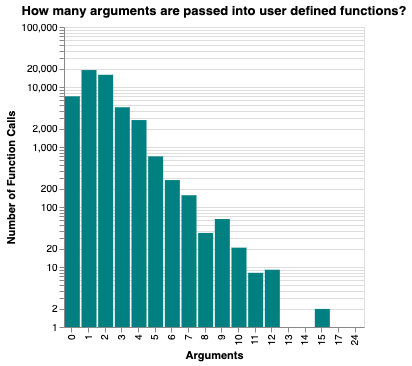

In [198]:
alt.Chart(
    user_df.parameters.value_counts().reset_index().rename(columns={'index':'Arguments', 'parameters': 'Count'}),
    width = 300, title = 'How many arguments are passed into user defined functions?'
).mark_bar(color='teal').encode(
    alt.X('Arguments:O'), 
    alt.Y('Count', title = 'Number of Function Calls', scale = alt.Scale(type='log'))
)

## Parameters of Non user-defined functions

In [199]:
non_user_idxs = [row.function not in row.user_funcs for _, row in all_df.iterrows()]
non_user_df = all_df[non_user_idxs]

In [200]:
non_user_df.head()

,file,user_funcs,function,parameters
0,0225kazuki..lstm..seq2seq_test.ipynb,"[CharTable.encode, CharTable.decode, CharTable...",sorted,1
1,0225kazuki..lstm..seq2seq_test.ipynb,"[CharTable.encode, CharTable.decode, CharTable...",dict,1
2,0225kazuki..lstm..seq2seq_test.ipynb,"[CharTable.encode, CharTable.decode, CharTable...",np.zeros,1
3,0225kazuki..lstm..seq2seq_test.ipynb,"[CharTable.encode, CharTable.decode, CharTable...",enumerate,1
4,0225kazuki..lstm..seq2seq_test.ipynb,"[CharTable.encode, CharTable.decode, CharTable...",join,1


In [201]:
non_user_mean_params = non_user_df.parameters.mean()
print("On average, a call to a non user-defined function has {0} parameters.".format(
    round(non_user_mean_params, 3)
))

On average, a call to a non user-defined function has 1.017 parameters.


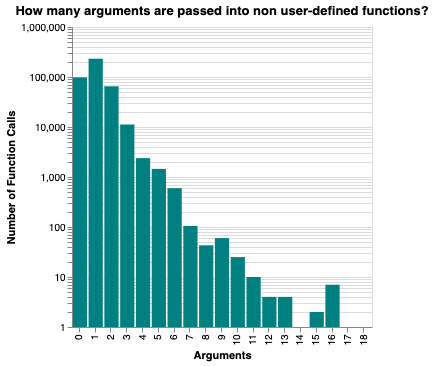

In [202]:
alt.Chart(
    non_user_df.parameters.value_counts().reset_index().rename(columns = {'index':'Arguments','parameters':'Count'}),
    width = 300, title = 'How many arguments are passed into non user-defined functions?'
).mark_bar(color='teal').encode(
    alt.X('Arguments:O'), 
    alt.Y('Count', title = 'Number of Function Calls', scale = alt.Scale(type='log'))
)

## On average, are there the same number of parameters in user-defined and non user-defined functions?

In [233]:
xbar_non = non_user_df.parameters.mean()
n_non = len(non_user_df)
s2_non = non_user_df.parameters.var()

xbar_user = user_df.parameters.mean()
n_user = len(user_df)
s2_user = user_df.parameters.var()

t = (xbar_user - xbar_non) / math.sqrt(s2_non/n_non + s2_user/n_user)
df = n_non + n_user - 2

if t > 0:
    p_value = 1-st.t.cdf(t, df)
else:
    p_value = st.t.cdf(t, df)
    
print(round(t, 3), df, p_value)


110.488 462255 0.0


With a t statistic of 100.103 and a p-value of 0, there is very strong evidence to reject the null hypothesis and conclude that on average, the number of parameters in a user-defined function is different from that of a non user-defined function.

In [234]:
lower = (xbar_user - xbar_non) - st.t.ppf(0.975, df)*math.sqrt(s2_non/n_non + s2_user/n_user)
upper = (xbar_user - xbar_non) + st.t.ppf(0.975, df)*math.sqrt(s2_non/n_non + s2_user/n_user)
print("""We are 95% confident that the true average number of parameters in user-defined function calls is between {} and {} 
higher than the average number of parameters in non user-defined function calls.""".format(round(lower, 2), round(upper, 2)))


We are 95% confident that the true average number of parameters in user-defined function calls is between 0.62 and 0.64 
higher than the average number of parameters in non user-defined function calls.


# How many functions are called?

In [205]:
func_counts = function_use_df.groupby('file')['function'].count().reset_index().merge(
    cells.groupby('file')['cell_id'].count().reset_index().rename(columns={'cell_id':'num_cells'}),
    on = 'file'
)

In [206]:
mean_by_cell = (func_counts.function/func_counts.num_cells).mean()
med_by_cell = (func_counts.function/func_counts.num_cells).median()
print("On average, there are {0} function calls per code cell.".format(round(mean_by_cell, 2)))
print("Median = {0}.".format(round(med_by_cell, 2)))


On average, there are 2.43 function calls per code cell.
Median = 1.73.


In [207]:
mean_by_nb = func_counts.function.mean()
med_by_nb = func_counts.function.median()
print("On average, there are {0} function calls per notebook.".format(round(mean_by_nb, 2)))
print("Median = {0}.".format(round(med_by_nb, 2)))


On average, there are 32.04 function calls per notebook.
Median = 26.0.


## How many user-defined functions are in a notebook?

In [208]:
counts_by_nb = function_defs_df.groupby('file')['function'].count().reset_index()

to_append = {'file':[], 'function':[]}
for file in cells['file'].unique():
    if file not in counts_by_nb['file']:
        to_append['file'].append(file)
        to_append['function'].append(0)
        
counts_by_nb = pd.concat([
    counts_by_nb, 
    pd.DataFrame(to_append)
])

In [209]:
mean_by_nb = counts_by_nb.function.mean()
med_by_nb = counts_by_nb.function.median()
print("On average, a user defines {0} functions per notebook.".format(round(mean_by_nb,2)))
print("Median = {0}.".format(round(med_by_nb, 2)))

mean_by_fun_nb = counts_by_nb[counts_by_nb.function != 0].function.mean()
med_by_fun_nb = counts_by_nb[counts_by_nb.function != 0].function.median()
print(("\nOn average, within a notebook that has "+
      "user defined functions, a user defines {0} functions per notebook.").format(round(mean_by_fun_nb,2)))
print("Median = {0}.".format(round(med_by_fun_nb, 2)))

On average, a user defines 1.84 functions per notebook.
Median = 0.0.

On average, within a notebook that has user defined functions, a user defines 5.85 functions per notebook.
Median = 3.0.


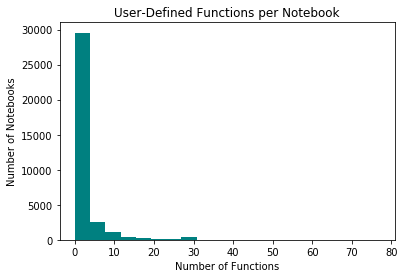

In [210]:
plt.hist(counts_by_nb.function, bins = 20, color = 'teal')
plt.title('User-Defined Functions per Notebook')
plt.xlabel('Number of Functions')
plt.ylabel('Number of Notebooks')
plt.show()


## How many times is each user-defined function called in a notebook?

In [211]:
user_uses = user_df.groupby(['file','function'])['parameters'].count().reset_index().rename(columns={'parameters':'count'})
user_uses_mean = user_uses['count'].mean()
user_uses_med = user_uses['count'].median()

print('On average, a user defined function is called {0} times in the notebook its defined.'.format(
    round(user_uses_mean, 3)
))
print('Median = {0}'.format(user_uses_med))

On average, a user defined function is called 1.595 times in the notebook its defined.
Median = 1.0


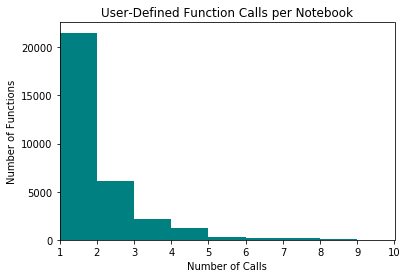

In [212]:
plt.hist(user_uses['count'], bins = range(10), color = 'teal')
plt.title('User-Defined Function Calls per Notebook')
plt.xlabel('Number of Calls')
plt.xlim(1,10)
plt.ylabel('Number of Functions')
plt.show()

## How many non user-defined functions are used?

In [213]:
non_user_uses = non_user_df.groupby(['file','function'])['parameters'].count().reset_index().rename(
    columns={'parameters':'count'}
)

In [214]:
non_user_counts = non_user_uses.groupby(['file'])['function'].count().reset_index()

to_append = {
    'file': [],
    'function': []
}

for file in notebooks.file.unique():
    if file not in non_user_counts.file:
        to_append['file'].append(file)
        to_append['function'].append(0)

non_user_counts = pd.concat([non_user_counts, pd.DataFrame(to_append)])

In [215]:
mean_by_nb = non_user_counts.function.mean()
med_by_nb = non_user_counts.function.median()

print("On average, a notebook uses {0} distinct non user-defined functions.".format(
    round(mean_by_nb, 3)
))
print("Median = {0}.".format(med_by_nb))

mean_by_fun_nb = non_user_counts[non_user_counts.function != 0].function.mean()
med_by_fun_nb = non_user_counts[non_user_counts.function != 0].function.median()

print("\nOn average, a notebook that uses non user-defined functions {0} distinct non user-defined functions.".format(
    round(mean_by_fun_nb, 3)
))
print("Median = {0}.".format(med_by_fun_nb))

prop_use = sum(non_user_counts.function != 0) / len(non_user_counts)
print('\n{0}% of notebooks use at least one non user-defined function.'.format(round(100*prop_use), 2))

On average, a notebook uses 8.083 distinct non user-defined functions.
Median = 0.0.

On average, a notebook that uses non user-defined functions 25.944 distinct non user-defined functions.
Median = 22.0.

31% of notebooks use at least one non user-defined function.


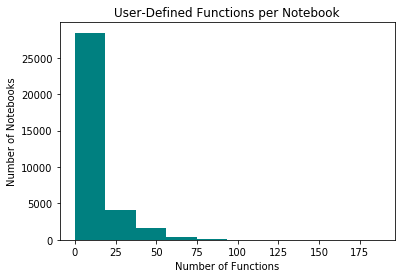

In [216]:
plt.hist(non_user_counts.function, color = 'teal')
plt.title('User-Defined Functions per Notebook')
plt.xlabel('Number of Functions')
plt.ylabel('Number of Notebooks')
plt.show()


## How many times is each non user-defined function called in a notebook?

In [217]:
mean_by_nb = non_user_uses['count'].mean()
med_by_nb = non_user_uses['count'].median()

print("On average, a non user-defined function is used {0} times in a notebook.".format(
    round(mean_by_nb, 3)
))
print("Median = {0}.".format(med_by_nb))

On average, a non user-defined function is used 1.461 times in a notebook.
Median = 1.0.


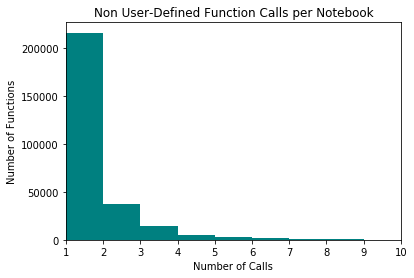

In [218]:
plt.hist(non_user_uses['count'], bins = range(10), color = 'teal')
plt.title('Non User-Defined Function Calls per Notebook')
plt.xlabel('Number of Calls')
plt.xlim(1,10)
plt.ylabel('Number of Functions')
plt.show()


## On average, are there the same number of uses of user-defined and non user-defined functions?

In [231]:
xbar_non = non_user_uses['count'].mean()
n_non = len(non_user_uses)
s2_non = non_user_uses['count'].var()

xbar_user = user_uses['count'].mean()
n_user = len(user_uses)
s2_user = user_uses['count'].var()

t = (xbar_user - xbar_non) / math.sqrt(s2_non/n_non + s2_user/n_user)
df = n_non + n_user - 2

if t > 0:
    p_value = 1-st.t.cdf(t, df)
else:
    p_value = st.t.cdf(t, df)
    
print(round(t, 3), df, p_value)


18.182 313489 0.0


With a t statistic of 18.18 and a p-value of 0, there is very strong evidence to reject the null hypothesis and conclude that on average, the number of uses of a user-defined function is different from that of a non user-defined function.

In [232]:
lower = (xbar_user - xbar_non) - st.t.ppf(0.975, df)*math.sqrt(s2_non/n_non + s2_user/n_user)
upper = (xbar_user - xbar_non) + st.t.ppf(0.975, df)*math.sqrt(s2_non/n_non + s2_user/n_user)
print("""We are 95% confident that the true average number of calls to a user-defined function is between {} and {} 
higher than the average number of calls to a non user-defined function.""".format(round(lower, 2), round(upper, 2)))


We are 95% confident that the true average number of calls to a user-defined function is between 0.12 and 0.15 
higher than the average number of calls to a non user-defined function.


<center> <a href = 8_Struggles.ipynb>Struggles &lt;</a> | </center>